<a href="https://colab.research.google.com/github/JAYESH2505/Brain_Tumor_CNN/blob/main/Brain_Tumor_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project
## Using CNN to Identify Various Brain Tumors in Patients During Early Stages to Prevent Fatalities
This project leverages Convolutional Neural Networks (CNNs) and PyTorch to analyze Brain Tumor MRI Scans and classify them as tumor or no tumor. The goal is to assist in the early detection of brain tumors, potentially saving lives by enabling timely medical intervention.

###**Download DataSet**

In [ ]:
pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d rm1000/brain-tumor-mri-scans

Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
brain-tumor-mri-scans.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip File
import zipfile
with zipfile.ZipFile("brain-tumor-mri-scans.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_dataset")

In [ ]:
# View
import os
os.listdir("brain_tumor_dataset")

['meningioma', 'pituitary', 'healthy', 'glioma']

###**Split Data into Train and Test Sets**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source folder and target folder paths
source_folder = "brain_tumor_dataset"  # Adjust the path to where your dataset is located
target_folder = "data_split"  # The folder where you want to save the split data

# Define train-test split ratio
test_size = 0.2  # 20% for testing

# Create train and test directories
for split in ['train', 'test']:
    for category in ['meningioma', 'pituitary', 'healthy', 'glioma']:
        os.makedirs(os.path.join(target_folder, split, category), exist_ok=True)

# Split and move files
for category in ['meningioma', 'pituitary', 'healthy', 'glioma']:
    category_path = os.path.join(source_folder, category)
    files = os.listdir(category_path)
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    for split, split_files in zip(['train', 'test'], [train_files, test_files]):
        for file in split_files:
            shutil.copy(os.path.join(category_path, file),
                        os.path.join(target_folder, split, category))

print("Data has been split into train and test sets.")


Data has been split into train and test sets.


### **Preprocessing**

In [ ]:
# Importing Dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [ ]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### **Load the Data**

In [ ]:
# Import Dependecies
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset=ImageFolder(root="data_split/train",transform=transform)
test_dataset=ImageFolder(root="data_split/test",transform=transform)

train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=True)

In [ ]:
print(f"Train DataSet {train_dataset} \n Test DataSet {test_dataset}")

Train DataSet Dataset ImageFolder
    Number of datapoints: 5617
    Root location: data_split/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 
 Test DataSet Dataset ImageFolder
    Number of datapoints: 1406
    Root location: data_split/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
print(f"Train Data Loader {train_dataloader} \n Test Data Loader {test_dataloader}")

Train Data Loader <torch.utils.data.dataloader.DataLoader object at 0x7ede8dc30790> 
 Test Data Loader <torch.utils.data.dataloader.DataLoader object at 0x7ede8dc32230>


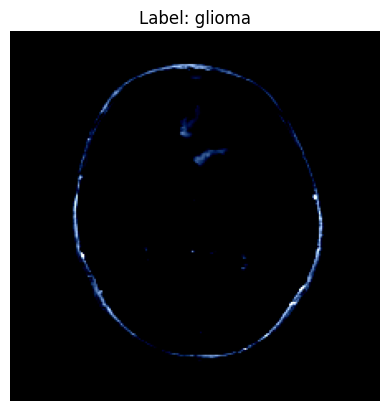

In [ ]:
def show_single_image(loader):
    # Get one batch of data
    images, labels = next(iter(loader))

    # Get the first image and its corresponding label
    image = images[0]
    label = labels[0]

    # Convert the image tensor to numpy for display
    image = image.permute(1, 2, 0).numpy()

    # Use the labels to get the category name from the dataset's class_to_idx
    class_names = loader.dataset.classes
    label_name = class_names[label]

    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Assuming train_loader is the DataLoader for the training dataset
show_single_image(train_dataloader)

### **Use a Pre-Trained Model (e.g., ResNet18)**

In [ ]:
from torchvision.models import resnet18

In [ ]:
# Load the pre-trained ResNet18 model
model = resnet18(pretrained=True)

# Modify the final fully connected layer to output 4 classes
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 classes: meningioma, pituitary, healthy, glioma

# Move the model to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print the model architecture
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### **Define Loss Function and Optimizer**

In [ ]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

### **Train the Model**

In [ ]:
import torch

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """
    Perform a single training step (batch processing) for one epoch.

    Args:
    - model (torch.nn.Module): The neural network model.
    - dataloader (torch.utils.data.DataLoader): The data loader for the training set.
    - loss_fn (torch.nn.Module): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer used to update the model's weights.
    - device (torch.device): The device (GPU or CPU) on which to perform the computations.

    Returns:
    - train_loss (float): The average training loss for this step.
    - train_acc (float): The average training accuracy for this step.
    """

    # Put the model in training mode
    model.train()

    # Initialize variables for loss and accuracy tracking
    train_loss, train_acc = 0, 0

    # Iterate through the dataloader (train data batches)
    for X, y in dataloader:
        # Move the data to the selected device (GPU or CPU)
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Zero the gradients
        optimizer.zero_grad()

        # 4. Perform backward pass (calculate gradients)
        loss.backward()

        # 5. Update model parameters
        optimizer.step()

        # 6. Calculate accuracy for this batch
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Calculate the average loss and accuracy across all batches
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


In [ ]:
def train_model(model: torch.nn.Module,
                train_loader: torch.utils.data.DataLoader,
                val_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                epochs: int,
                device: torch.device):
    """
    Train the model over multiple epochs using the provided data loaders, loss function, and optimizer.

    Args:
    - model (torch.nn.Module): The neural network model.
    - train_loader (torch.utils.data.DataLoader): The DataLoader for the training data.
    - val_loader (torch.utils.data.DataLoader): The DataLoader for the validation data.
    - loss_fn (torch.nn.Module): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer to use.
    - epochs (int): The number of epochs to train the model.
    - device (torch.device): The device (GPU or CPU) to use.

    Returns:
    - None: This function trains the model and prints loss and accuracy.
    """

    # Move the model to the target device (GPU or CPU)
    model.to(device)

    from tqdm import tqdm
    # Training loop
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model for this epoch
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)

        # Print training stats for the epoch
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%")

        # Optionally: You can add a validation step here to track the validation performance

        # Add a validation step after each epoch (if needed)
        if val_loader is not None:
            val_loss, val_acc = validate_model(model, val_loader, loss_fn, device)
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc*100:.2f}%")

        print("-" * 50)


def validate_model(model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   device: torch.device):
    """
    Validate the model on the validation dataset.

    Args:
    - model (torch.nn.Module): The trained neural network model.
    - dataloader (torch.utils.data.DataLoader): The validation data loader.
    - loss_fn (torch.nn.Module): The loss function.
    - device (torch.device): The device (GPU or CPU) for computation.

    Returns:
    - val_loss (float): The average validation loss.
    - val_acc (float): The average validation accuracy.
    """

    model.eval()  # Set the model to evaluation mode
    val_loss, val_acc = 0, 0

    with torch.no_grad():  # Disable gradient computation for validation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate and accumulate validation loss
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # Calculate accuracy for this batch
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            val_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Average the loss and accuracy across all validation batches
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)

    return val_loss, val_acc


In [ ]:
train_model(model, train_dataloader,None, loss_function, optimizer, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


 10%|█         | 1/10 [00:38<05:45, 38.44s/it]

Train Loss: 0.1681, Train Accuracy: 93.87%
--------------------------------------------------
Epoch 2/10


 20%|██        | 2/10 [01:17<05:11, 38.88s/it]

Train Loss: 0.1420, Train Accuracy: 95.13%
--------------------------------------------------
Epoch 3/10


 30%|███       | 3/10 [01:56<04:31, 38.82s/it]

Train Loss: 0.1108, Train Accuracy: 96.13%
--------------------------------------------------
Epoch 4/10


 40%|████      | 4/10 [02:36<03:55, 39.19s/it]

Train Loss: 0.0777, Train Accuracy: 97.09%
--------------------------------------------------
Epoch 5/10


 50%|█████     | 5/10 [03:14<03:15, 39.06s/it]

Train Loss: 0.0798, Train Accuracy: 97.25%
--------------------------------------------------
Epoch 6/10


 60%|██████    | 6/10 [03:55<02:38, 39.70s/it]

Train Loss: 0.0567, Train Accuracy: 98.01%
--------------------------------------------------
Epoch 7/10


 70%|███████   | 7/10 [04:39<02:03, 41.12s/it]

Train Loss: 0.0553, Train Accuracy: 97.94%
--------------------------------------------------
Epoch 8/10


 80%|████████  | 8/10 [05:25<01:24, 42.38s/it]

Train Loss: 0.0445, Train Accuracy: 98.49%
--------------------------------------------------
Epoch 9/10


 90%|█████████ | 9/10 [06:11<00:43, 43.59s/it]

Train Loss: 0.0605, Train Accuracy: 97.80%
--------------------------------------------------
Epoch 10/10


100%|██████████| 10/10 [06:59<00:00, 41.91s/it]

Train Loss: 0.0374, Train Accuracy: 98.69%
--------------------------------------------------


### **Model From  Scratch**

In [ ]:
class BrainTumorClassifier(nn.Module):
  def __init__(self,input_shape,hidden_units,output_shape):
    super().__init__()

    self.convBlock1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU()
    )

    self.convBlock2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU()
        )
    self.convBlock3=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU()
        )
    self.linear=nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=2),
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*27*27,out_features=output_shape)
    )

  def forward(self,x):
    return self.linear(self.convBlock3(self.convBlock2(self.convBlock1(x))))

In [ ]:
Model_Classifier=BrainTumorClassifier(input_shape=3,hidden_units=10,output_shape=4)

In [ ]:
Model_Classifier

BrainTumorClassifier(
  (convBlock1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (convBlock3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (linear): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=7290, out_features=4, bias=True)
  )
)

### **Evaluate and Save the Model**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    print(classification_report(actuals, predictions))
    print(confusion_matrix(actuals, predictions))

evaluate_model(model, test_dataloader)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       325
           1       0.75      0.01      0.03       400
           2       0.23      0.55      0.32       329
           3       0.29      0.49      0.36       352

    accuracy                           0.26      1406
   macro avg       0.32      0.26      0.18      1406
weighted avg       0.34      0.26      0.17      1406

[[  0   1 222 102]
 [  1   6 216 177]
 [  1   0 181 147]
 [  0   1 178 173]]


### **Save the Model**

In [ ]:
torch.save(model.state_dict(), 'brain_tumor_model.pth')

### **Custome Image**

In [ ]:
from PIL import Image
from torchvision import transforms
import torch

# Define the same transformation as used in training
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224 (as expected by ResNet)
    transforms.ToTensor(),            # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet values
])

def predict_image(image_path, model, device):
    # Load the image
    image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format

    # Apply the transformations
    image = transform(image)

    # Add an extra batch dimension (since the model expects a batch)
    image = image.unsqueeze(0)

    # Send the image to the same device as the model
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation (not needed for inference)
    with torch.no_grad():
        # Get model prediction
        output = model(image)

        # Get the predicted class (the class with the highest score)
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

# Example usage:
image_path = "Temp.jpg"  # Path to your custom image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predicted_class = predict_image(image_path, model, device)

# Map the predicted class to your class labels
class_names = ['glioma','healthy','meningioma', 'pituitary']
print(f"Predicted class: {class_names[predicted_class]}")


Predicted class: glioma


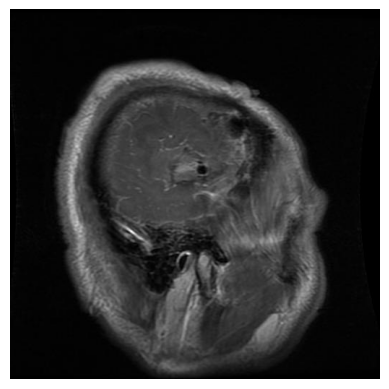

In [ ]:
import matplotlib.pyplot as plt

# Function to display the image
def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Display the image
show_image(image_path)


### **Load Model Parameters**

In [ ]:
state_dict = torch.load('brain_tumor_model.pth', weights_only=True)
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>